<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/env_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# キュウリの茎径の環境データ分析
<img width=50% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/f938b2a7dc3092fa908c41a5602ad0eeb877e1591820f7f9335ab3a0bcd72116.png">

## ライセンス
- 環境センサデータ（csvデータ）
    - Makoto Koike氏提供
    - CC-BY-NC-4.0
- 本稿プログラムコード
    - Makoto Koike氏原案
    - CC-BY-NC-4.0

## 解説
- 本稿では、グリーンハウスの環境データをもとに、主にpandasとplotlyを用いてデータを分析・可視化する方法を紹介します。
- 本稿で使用するデータは、グリーンハウスにおけるキュウリ栽培の過程で収集した温度・湿度を始めとした環境データに加え、キュウリの茎径（くきけい）を経時的に測定したものです。
- 茎径はキュウリの生育状態や健康状態を表し、また、生育環境を反映する重要な指標とも考えられています。今回は環境データと茎径の関係を、データ分析を通じて理解を試みます。

## 環境構築

In [1]:
#　このセルを実行した後、ラインタイムを再起動すること。
!apt-get -y install fonts-ipafont-gothic
!pip install lida==0.0.10
!pip install -U -q kaleido

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 2s (5,480 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [2]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import Image
import statsmodels.api as sm

# グラフを図として出力する場合の日本語表示設定。
default_template = pio.templates['plotly']
default_template.layout.font.family = "IPAゴシック"
default_template.layout.font.size = 12
default_template.layout.font.color = "black"
pio.templates.default = default_template


## 実行コード

### 1. CSVデータを読み込む

Pythonでcsvファイルを扱うには、**pandas（パンダス）**というライブラリを使用します。
まずライブラリを使うために、import文でpandasをプログラムに組み込みます。そして、csvファイルを読み込むには**pd.read_csv関数**を使用します。この時、もしcsvファイルの１行目にデータの項目名などが記載されている場合には、header引数を使って項目名の行番号を指定します。"header=0"であれば、先頭の行をデータ項目名が記載されているという意味になります。また、日付データとして読み込みたいデータ項目は、"parse_dates=['項目名1', '項目名2', ...]"と指定します。

最後に、読み込んだcsvデータを画面に表示しています。



In [3]:
!mkdir data
!wget -O data/example.csv https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/dataframeanalysis/cucumber_house_data.csv?raw=true
df = pd.read_csv('data/example.csv', header=0, parse_dates=['日時'], encoding='shift-jis')
df

--2024-05-20 14:33:59--  https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/assets/dataframeanalysis/cucumber_house_data.csv?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/phytometrics/plant_phenotyping_python/raw/main/notebooks/assets/dataframeanalysis/cucumber_house_data.csv [following]
--2024-05-20 14:34:00--  https://github.com/phytometrics/plant_phenotyping_python/raw/main/notebooks/assets/dataframeanalysis/cucumber_house_data.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/assets/dataframeanalysis/cucumber_house_data.csv [following]
--2024-05-20 14:34:00--  https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/assets

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
0,2021-06-08 00:00:00,0.943,19.15,89.82,1009.00,0,1,527,25.10,27.7
1,2021-06-08 00:01:00,0.944,19.19,89.58,1008.98,0,0,527,25.05,27.6
2,2021-06-08 00:02:00,0.944,19.16,89.11,1008.98,0,0,526,25.25,27.6
3,2021-06-08 00:03:00,0.943,19.10,89.12,1009.00,0,0,523,25.15,27.5
4,2021-06-08 00:04:00,0.943,19.07,89.27,1008.96,0,0,523,25.05,27.4
...,...,...,...,...,...,...,...,...,...,...
33731,2021-07-02 23:54:00,1.795,24.28,93.26,1003.30,0,0,547,24.50,28.6
33732,2021-07-02 23:55:00,1.795,24.29,93.26,1003.27,0,0,549,24.55,28.6
33733,2021-07-02 23:56:00,1.795,24.30,93.24,1003.27,0,0,550,24.65,28.6
33734,2021-07-02 23:57:00,1.795,24.32,93.27,1003.30,0,0,550,24.60,28.5


---
### 2. データ形式について
#### 2.1 データの取得

pandasは、**DataFrame（データフレーム）**という形式でCSVデータを格納しています。各データへのアクセスは、データの**インデックス**や**カラム名**を用いておこないます。

例えば、「気温」のデータを取得したい場合は**df['気温']**のように大括弧の中にアクセスしたいカラムの名前を記述します。


※カラム名は文字列であるため「’（シングルクォーテーション）」で囲む必要があります



In [4]:
# 気温データのみ
df['気温']

0        19.15
1        19.19
2        19.16
3        19.10
4        19.07
         ...  
33731    24.28
33732    24.29
33733    24.30
33734    24.32
33735    24.33
Name: 気温, Length: 33736, dtype: float64

In [5]:
# 気温と土壌温度（複数カラムの場合は大括弧の中で列挙する）
df[['気温', '土壌温度']]


,気温,土壌温度
0,19.15,25.10
1,19.19,25.05
2,19.16,25.25
3,19.10,25.15
4,19.07,25.05
...,...,...
33731,24.28,24.50
33732,24.29,24.55
33733,24.30,24.65
33734,24.32,24.60


In [6]:
# 10～12番目のデータを表示します。
df[10:12]

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
10,2021-06-08 00:10:00,0.944,18.81,89.62,1008.90,0,0,526,25.15,27.7
11,2021-06-08 00:11:00,0.944,18.76,89.64,1008.92,0,1,526,25.10,27.7


### 2.2 日時範囲を指定したデータの取得

pandasは日時フォーマットのデータを使用することができます。代表的な**日時フォーマットは『年-月-日 時:分:秒』**のように記述します。日付だけや時間だけの記述も許可されています。

ある期間のデータだけを取得したい場合は、**querry関数**を用います。querry関数は、取得したいデータの条件を文字列として記述し渡すことで、条件に合ったデータを抽出することが可能です。

In [7]:
df.query("'2021-06-20' <= 日時 < '2021-06-21'") # ダブルクォーテーションとシングルクオーテーションの位置に注意

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
15902,2021-06-20 00:00:00,1.495,20.22,90.51,991.56,0,0,517,24.00,28.6
15903,2021-06-20 00:01:00,1.494,20.22,90.49,991.54,0,0,517,24.00,28.5
15904,2021-06-20 00:02:00,1.494,20.24,90.49,991.54,0,1,517,24.00,28.6
15905,2021-06-20 00:04:00,1.495,20.24,90.51,991.54,0,0,517,24.00,28.5
15906,2021-06-20 00:05:00,1.494,20.23,90.54,991.54,0,1,517,24.00,28.5
...,...,...,...,...,...,...,...,...,...,...
17266,2021-06-20 23:55:00,1.490,19.13,71.53,994.92,0,0,413,24.30,31.3
17267,2021-06-20 23:56:00,1.490,19.15,70.77,994.92,0,1,415,24.40,31.3
17268,2021-06-20 23:57:00,1.490,19.17,70.60,994.90,0,0,418,24.45,31.3
17269,2021-06-20 23:58:00,1.489,19.19,70.86,994.92,0,0,422,24.35,31.4


---
## 3.可視化してみる

まずは簡易的に各データをグラフにしてプロットしてみましょう。データの可視化には、**plotly（プロットリー）**というライブラリを使用します。

[https://plotly.com/python/](https://plotly.com/python/)

plotlyはグラフ描画のためのライブラリで、プログラムから簡単に折れ線グラフや散布図など各種グラフを描画することが可能です。

```
<主要なグラフと描画関数>
px.line()       : 折れ線グラフ
px.scatter()    : 散布図
px.bar()        : 棒グラフ
px.pie()        : パイチャート
px.histogram()  : ヒストグラム
px.box()        : 箱ひげ図
```

### 3.1 基本的な折れ線グラフ

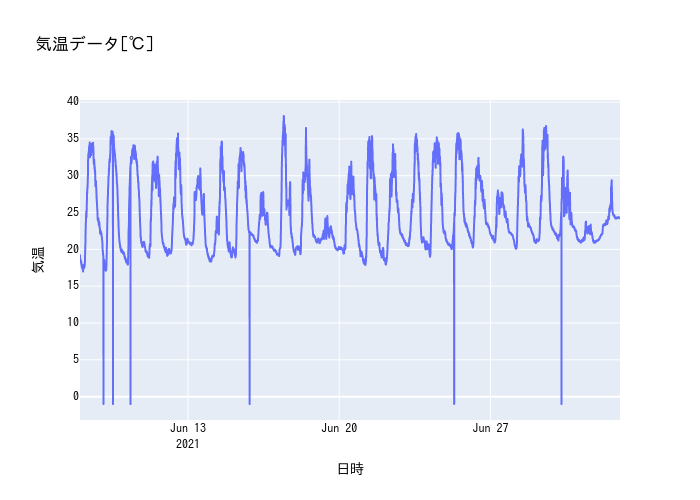

In [8]:
# オンラインのみで表示可能なインタラクティブ方式。、
# オフライン時には環境によって描画されないのでこの次のセルの形式で以後進める。
# px.line(df, x='日時', y='気温', title='気温データ[℃]')
fig = px.line(df, x='日時', y='気温', title='気温データ[℃]')
fig.write_image('my_plot.png')
Image('my_plot.png')

相対湿度も見てましょう。

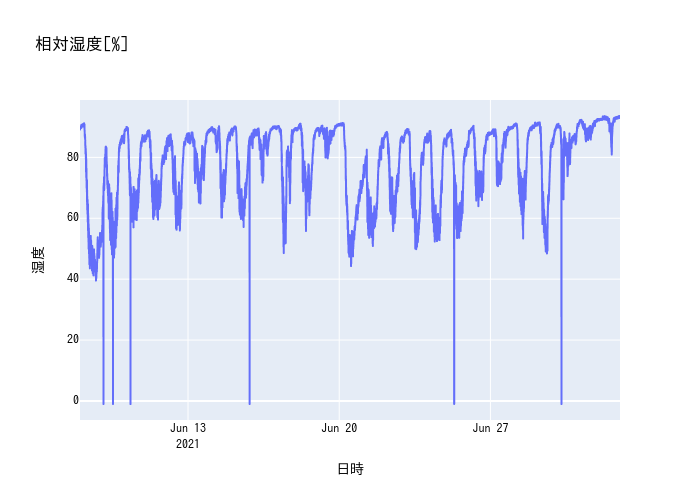

In [9]:
# px.line(df, x="日時", y="湿度", title="相対湿度[%]")
fig = px.line(df, x="日時", y="湿度", title="相対湿度[%]")
fig.write_image('my_plot.png')
Image('my_plot.png')

### 3.2 複数のデータをプロット

複数のデータ項目をプロットする場合は、**y=['項目1', '項目2', ... ]**のように大括弧の中に項目を列挙する。

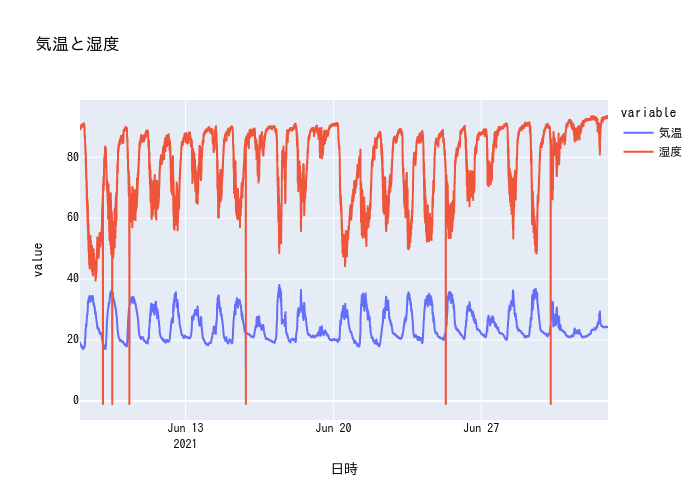

In [10]:
# px.line(df, x='日時', y=['気温', '湿度'], title='気温と湿度')
fig = px.line(df, x='日時', y=['気温', '湿度'], title='気温と湿度')
fig.write_image('my_plot.png')
Image('my_plot.png')

### 📝 補足：より高度なプロット

複数データを同時にプロットする場合、px.line関数では１枚のグラフに全てのデータを描画するため、データのスケールが異なるととても見辛いグラフになってしまいます。このような時は、下記のようにsubplotsを使用することで複数のグラフに分けてプロットすることも可能です。下記の例では、make_subplots関数を使って事前に6行×1列のグラフ描画領域を確保し、add_trace関数を使って指定した行列位置（rowとcol）にそれぞれのグラフを描画しています。

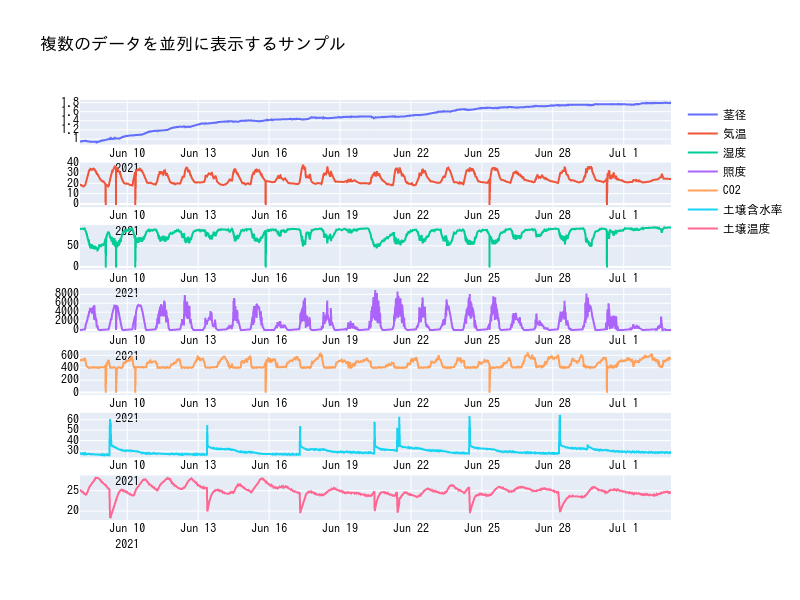

In [11]:
fig = make_subplots(rows=7, cols=1) # make_subplots関数で表示数を指定（左記の例だと7行1列）
fig.add_trace(go.Scatter(x=df['日時'], y=df['茎径'], name='茎径'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['気温'], name='気温'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['湿度'], name='湿度'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['照度'], name='照度'), row=4, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['CO2'], name='CO2'), row=5, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['土壌含水率'], name='土壌含水率'), row=6, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['土壌温度'], name='土壌温度'), row=7, col=1)
fig.update_layout(height=600, width=800, title_text='複数のデータを並列に表示するサンプル')
#fig.show()
fig.write_image('my_plot.png')
Image('my_plot.png')

---
# 4.外れ値処理

グラフを確認すると、気温、湿度、CO2などで異常な値が３か所あることがわかります。このような通常ではありえない、又は、他と比較して明らかに異なるような値を**「外れ値」**と呼びます。外れ値がデータに含まれてしまう原因は様々で、例えばセンサのノイズや通信エラーなどの影響が考えられます。

一般的に、外れ値はデータ分析を行う上でのノイズとなるため事前に処理しておきます。

## 4.1 外れ値を削除する

グラフを見ると、気温、湿度、CO2で「-1」という**明らかにあり得ない値**があることが分かります。異常な値のため、一旦削除することにします。

※今回のようにありえない値のことを「異常値」と呼び、外れ値とは別で扱う場合もあります

※外れ値の判定方法には統計的検定や四分位範囲を使った方法などがあります

In [12]:
df.query("気温 < 0")

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
1463,2021-06-09 02:02:00,0.988,-1.0,-1.0,-1.0,-1,-1,-1,26.30,26.4
1464,2021-06-09 02:04:00,0.987,-1.0,-1.0,-1.0,-1,-1,-1,26.25,26.6
1465,2021-06-09 02:05:00,0.986,-1.0,-1.0,-1.0,-1,-1,-1,26.30,26.4
2064,2021-06-09 12:38:00,1.012,-1.0,-1.0,-1.0,-1,-1,-1,22.80,33.1
2065,2021-06-09 12:39:00,1.011,-1.0,-1.0,-1.0,-1,-1,-1,22.85,33.1
2066,2021-06-09 12:40:00,1.012,-1.0,-1.0,-1.0,-1,-1,-1,22.85,33.2
2067,2021-06-09 12:41:00,1.012,-1.0,-1.0,-1.0,-1,-1,-1,22.85,33.1
2899,2021-06-10 08:06:00,1.086,-1.0,-1.0,-1.0,-1,-1,-1,24.80,30.1
10278,2021-06-15 20:27:00,1.411,-1.0,-1.0,-1.0,-1,-1,-1,27.30,27.3
23194,2021-06-25 07:42:00,1.686,-1.0,-1.0,-1.0,-1,-1,-1,23.80,32.2


In [13]:
# -1を"値なし（NaN: Not a Number）"に置き換える

df = df.replace(-1, np.nan)

In [14]:
df[1463: 1466]

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
1463,2021-06-09 02:02:00,0.988,NaN,NaN,NaN,NaN,NaN,NaN,26.30,26.4
1464,2021-06-09 02:04:00,0.987,NaN,NaN,NaN,NaN,NaN,NaN,26.25,26.6
1465,2021-06-09 02:05:00,0.986,NaN,NaN,NaN,NaN,NaN,NaN,26.30,26.4


## 4.2 欠損（値なし）を補完する

一旦“値なし”に置き換えることで異常値を削除しました。しかし、このままだと“値なし”とした部分が欠損したままであるため、次に欠損箇所の補完をおこないます。


欠損値の補完方法は、
* 時系列で直前の値を使用する
* 平均値を使用する
* 線形補完を行う


など、これ以外にも様々な手法があります。今回は簡単な線形補完を使って欠損値を補完する方法をご紹介します。


### 線形補完

線形補完とは、欠損箇所の直前の値と直後の値を直線で結んだ直線上の値で欠損値を補完します。

pandasで線形補完を行うには、**interpolate関数**を使用します。欠損箇所（＝値なしの所）の前後の値を使って線形補完されますが、先頭や末尾のデータは無視されます。

In [15]:
df['気温'] = df['気温'].interpolate()

In [16]:
df[1463: 1466]

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
1463,2021-06-09 02:02:00,0.988,18.9075,NaN,NaN,NaN,NaN,NaN,26.30,26.4
1464,2021-06-09 02:04:00,0.987,18.8250,NaN,NaN,NaN,NaN,NaN,26.25,26.6
1465,2021-06-09 02:05:00,0.986,18.7425,NaN,NaN,NaN,NaN,NaN,26.30,26.4


In [17]:
# 湿度～CO2の列に対し線形補完を行う（補完した値で元データを上書きする）
df.loc[:, '湿度':'CO2'] = df.loc[:, '湿度':'CO2'].interpolate()

In [18]:
df[1463: 1466]

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率
1463,2021-06-09 02:02:00,0.988,18.9075,66.55,1006.515,0.0,0.0,434.25,26.30,26.4
1464,2021-06-09 02:04:00,0.987,18.8250,67.13,1006.530,0.0,0.0,433.50,26.25,26.6
1465,2021-06-09 02:05:00,0.986,18.7425,67.71,1006.545,0.0,0.0,432.75,26.30,26.4


補完後の気温データをプロットして確認してみます。

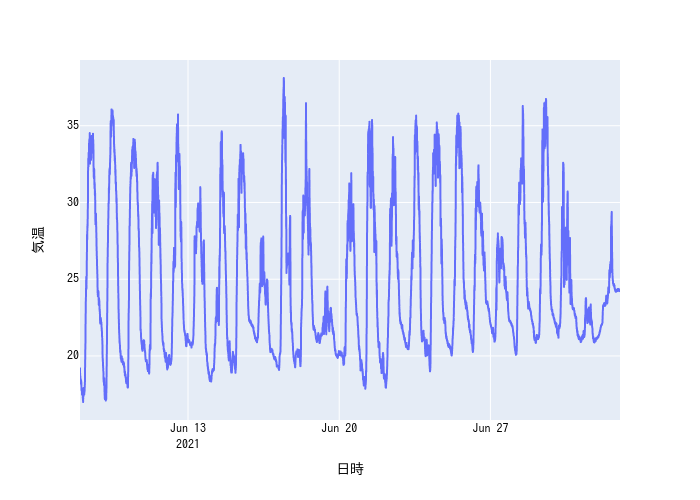

In [19]:
fig = px.line(df, x='日時', y='気温')
fig.write_image('my_plot.png')
Image('my_plot.png')

### 📝 補足：高度な範囲指定

**loc関数**を使うことで、データフレームの範囲を指定して値の抽出や代入を行うことができます。
```
df.loc[行範囲, 列範囲]
df.loc[行の開始位置:行の終了位置, 列の開始位置:列の終了位置]
なお、開始位置と終了位置を省略した場合は全範囲を指定したことになる
```
4.2の例では、行を全範囲、列を気温～CO2の範囲で指定したことになります。

---
# 5.飽差を計算してみよう

飽差とは、空気中にあとどれくらいの水蒸気を含むことができるかを表した指標です。値は大きくなるほど乾燥していることを示します。
農業においては主に光合成制御の指標として用いられています。


## VPD (Vapor Pressure Deficit)
単位は\[hPa\]で飽和水蒸気圧と現在の水蒸気圧の差を示す。一般的にはTetensの式（飽和水蒸気圧の近似式）を用いて、以下式で近似値を求めることができる。

$ VPD = \left\{ 6.1078 \times 10^{\left( \frac{7.5 \times T}{T + 237.3} \right)} \right\} \times \left(1 - \frac{RH}{100}\right)

ここで、Tは気温\[℃\]、RHは相対湿度\[%\]とする。


## HD (Humidity Deficit)
単位は\[g/m^3\]で飽和水蒸気量と現在の水蒸気量の差を示す。
VPDとは下記式で相互変換することができる。

$ HD = \frac{VPD × 216.674}{T + 273.15} $


## 5.1 飽差（VPD・HD）の関数を定義する

気温と相対湿度からVPD・HDを算出する関数を定義します。

In [20]:
def vpd(t, rh):
  return 6.1078 * 10**((7.5 * t) / (t + 237.3)) * (1 - rh/100)

def hd(vpd_val, t):
    return (vpd_val * 216.674) / (t + 273.15)

## 5.2 関数を使って飽差を計算

定義した関数を使って飽差を計算します。計算結果を下の飽差表と照らし合わせて値が合っているか確認してみてください。

気温|相対湿度|VPD|HD
---|---|---|--
30℃|40%|25.5|18.2
30℃|50%|21.2|15.2
30℃|60%|17.0|12.1
30℃|70%|12.7|9.1
30℃|80%|8.5|6.1
30℃|90%|4.2|3.0



In [21]:
vpd_val = vpd(30, 60)
print(vpd_val)
hd_val = hd(vpd_val, 30)
print(hd_val)

16.970539179206956
12.129555025945864


## 5.3 データの一括処理

現在の**df**に保存された気温と湿度のデータを使って一括で飽差の計算を行います。

一括処理には、**apply関数**を用います。apply関数はデータフレームに対して任意の関数を適用します。今回の場合は、気温と湿度のデータに対して先ほど定義したhd関数を適用し飽差を計算します。

In [22]:
df[['気温', '湿度']]

,気温,湿度
0,19.15,89.82
1,19.19,89.58
2,19.16,89.11
3,19.10,89.12
4,19.07,89.27
...,...,...
33731,24.28,93.26
33732,24.29,93.26
33733,24.30,93.24
33734,24.32,93.27


In [23]:
df['VPD'] = df.apply(lambda row: vpd(row['気温'], row['湿度']), axis=1)
df["HD"] = df.apply(lambda row: hd(row["VPD"], row["気温"]), axis=1)
df

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率,VPD,HD
0,2021-06-08 00:00:00,0.943,19.15,89.82,1009.00,0.0,1.0,527.0,25.10,27.7,2.257789,1.673637
1,2021-06-08 00:01:00,0.944,19.19,89.58,1008.98,0.0,0.0,527.0,25.05,27.6,2.316784,1.717134
2,2021-06-08 00:02:00,0.944,19.16,89.11,1008.98,0.0,0.0,526.0,25.25,27.6,2.416763,1.791419
3,2021-06-08 00:03:00,0.943,19.10,89.12,1009.00,0.0,0.0,523.0,25.15,27.5,2.405532,1.783460
4,2021-06-08 00:04:00,0.943,19.07,89.27,1008.96,0.0,0.0,523.0,25.05,27.4,2.367934,1.755765
...,...,...,...,...,...,...,...,...,...,...,...,...
33731,2021-07-02 23:54:00,1.795,24.28,93.26,1003.30,0.0,0.0,547.0,24.50,28.6,2.045026,1.489776
33732,2021-07-02 23:55:00,1.795,24.29,93.26,1003.27,0.0,0.0,549.0,24.55,28.6,2.046251,1.490618
33733,2021-07-02 23:56:00,1.795,24.30,93.24,1003.27,0.0,0.0,550.0,24.65,28.6,2.053553,1.495887
33734,2021-07-02 23:57:00,1.795,24.32,93.27,1003.30,0.0,0.0,550.0,24.60,28.5,2.046889,1.490932


# 6.移動平均

今回のように1分間隔という短い間隔でデータを集めると、変動が細かすぎて全体の傾向を掴みにくい場合があります。そんな時には、**移動平均**を計算することで変動を滑らかにして全体としての傾向を俯瞰することができます。



## 6.1 移動平均を求める

pandasを用いると移動平均を簡単に計算することができます。**rolling関数**を使ってデータに窓関数を適用することによって、ある区間の統計量を算出することができます。


5分間の移動平均を算出してみます。今回のデータは1分間隔であるため5個分のデータが5分間のデータとなります。そこで、rolling関数の引数に5と指定することで5分間隔のデータにまとめなおすことができます。なお、先頭の5に満たないデータは値なしとなることに注意して下さい。

In [39]:
df.iloc[:,1:].rolling(5).mean() # 5分毎の平均

,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率,VPD,HD,VPD移動平均,茎径移動平均,トレンド成分,季節成分,残差成分,トレンド成分以外
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.9434,19.134,89.380,1008.984,0.0,0.2,525.2,25.12,27.56,2.352960,1.744283,NaN,NaN,NaN,0.000516,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33731,1.7944,24.270,93.314,1003.360,0.0,0.4,543.6,24.54,28.64,2.027429,1.477006,2.032509,1.794810,NaN,0.000059,NaN,NaN
33732,1.7946,24.276,93.298,1003.330,0.0,0.2,544.4,24.55,28.62,2.033013,1.481044,2.032929,1.794783,NaN,0.000142,NaN,NaN
33733,1.7948,24.284,93.284,1003.304,0.0,0.2,546.0,24.56,28.58,2.038238,1.484811,2.033413,1.794757,NaN,0.000252,NaN,NaN
33734,1.7948,24.294,93.272,1003.292,0.0,0.2,547.8,24.57,28.56,2.043101,1.488303,2.034068,1.794733,NaN,0.000236,NaN,NaN


In [40]:
df.iloc[:,1:].rolling(5).sum() # 5分ごとの積算

,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率,VPD,HD,VPD移動平均,茎径移動平均,トレンド成分,季節成分,残差成分,トレンド成分以外
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.717,95.67,446.90,5044.92,0.0,1.0,2626.0,125.60,137.8,11.764801,8.721414,NaN,NaN,NaN,0.002582,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33731,8.972,121.35,466.57,5016.80,0.0,2.0,2718.0,122.70,143.2,10.137147,7.385031,10.162544,8.974050,NaN,0.000295,NaN,NaN
33732,8.973,121.38,466.49,5016.65,0.0,1.0,2722.0,122.75,143.1,10.165064,7.405220,10.164647,8.973917,NaN,0.000710,NaN,NaN
33733,8.974,121.42,466.42,5016.52,0.0,1.0,2730.0,122.80,142.9,10.191192,7.424053,10.167065,8.973783,NaN,0.001262,NaN,NaN
33734,8.974,121.47,466.36,5016.46,0.0,1.0,2739.0,122.85,142.8,10.215506,7.441516,10.170342,8.973667,NaN,0.001178,NaN,NaN


その他、rolling関数でまとめた後に、median():中央値、min():最小値、max()：最大値、std():標準偏差を計算することができます。

ここでは、1時間の移動平均を計算し“VPD移動平均”という新しい列に追加しています。

In [28]:
df['VPD移動平均'] = df['VPD'].rolling(60).mean()
df

,日時,茎径,気温,湿度,気圧,照度,照度_IR,CO2,土壌温度,土壌含水率,VPD,HD,VPD移動平均
0,2021-06-08 00:00:00,0.943,19.15,89.82,1009.00,0.0,1.0,527.0,25.10,27.7,2.257789,1.673637,NaN
1,2021-06-08 00:01:00,0.944,19.19,89.58,1008.98,0.0,0.0,527.0,25.05,27.6,2.316784,1.717134,NaN
2,2021-06-08 00:02:00,0.944,19.16,89.11,1008.98,0.0,0.0,526.0,25.25,27.6,2.416763,1.791419,NaN
3,2021-06-08 00:03:00,0.943,19.10,89.12,1009.00,0.0,0.0,523.0,25.15,27.5,2.405532,1.783460,NaN
4,2021-06-08 00:04:00,0.943,19.07,89.27,1008.96,0.0,0.0,523.0,25.05,27.4,2.367934,1.755765,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33731,2021-07-02 23:54:00,1.795,24.28,93.26,1003.30,0.0,0.0,547.0,24.50,28.6,2.045026,1.489776,2.033293
33732,2021-07-02 23:55:00,1.795,24.29,93.26,1003.27,0.0,0.0,549.0,24.55,28.6,2.046251,1.490618,2.033971
33733,2021-07-02 23:56:00,1.795,24.30,93.24,1003.27,0.0,0.0,550.0,24.65,28.6,2.053553,1.495887,2.034740
33734,2021-07-02 23:57:00,1.795,24.32,93.27,1003.30,0.0,0.0,550.0,24.60,28.5,2.046889,1.490932,2.035620


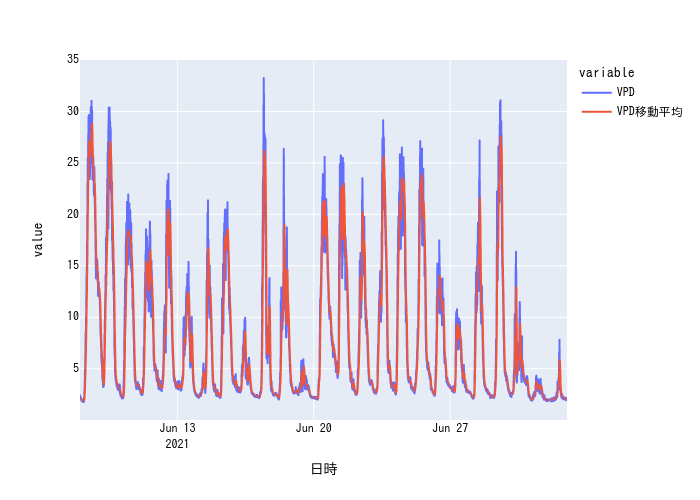

In [29]:
# 移動平均を取る前と取った後をグラフで比較
fig = px.line(df, x='日時', y=['VPD', 'VPD移動平均'])
fig.write_image('my_plot.png')
Image('my_plot.png')

---
# 7.相関分析

「体重測定を行った結果、身長が高い人ほど体重も重かった」というような、ある値の変化に連動して別の値も変化するような関係を相関関係といいます。そして、この連動具合を定量化した値を**相関係数**と呼びます。


相関分析は、複数のデータの相関係数を計算し**データ間の関係性**を見る時に用います。

### ＜相関係数＞
あるデータXが増加するのに合わせデータYも増加するような場合、2つのデータの相関係数は正の値になりデータ間には**正の相関がある**と言います。一方、あるデータXが増加するのに合わせデータYが減少するような場合、２つのデータの相関係数は負の値になりデータ間には**負の相関がある**と言います。一般的に、相関係数は-1.0～1.0の値を取り、
* (-1.0～-0.7) or (0.7～1.0)　：　強い相関がある
* (-0.7～-0.4) or (0.4～0.7)　：　相関がある
* (-0.4～-0.2) or (0.2～0.4)　：　やや相関がある
* (-0.2～0.0) or (0.0～0.2）　：　相関がない

と判断します（あくまで目安）。


## 7.1.茎径と飽差の相関係数

### ＜仮説＞
茎径の太さは、植物の水ストレスによって増減することが知られています。飽差が低く蒸散が活発に行われている状態では根からの給水が間に合わず蒸散により茎径が細くなると予想されます。また、逆に飽差が高い状態では蒸散が阻害されるため、根から給水した水分が茎に留まり茎径が太くなると予想されます。つまり、**茎径と飽差には負の相関**がありそうです。

仮説が正しいかデータ分析で検証してみましょう。

### 茎径の1時間移動平均を求める
茎径も飽差と同様に1時間間隔の移動平均を求めましょう。


In [30]:
df["茎径移動平均"] = df["茎径"].rolling(60).mean()

### 散布図を表示してみる

データの相関を見るときには、まず散布図を作成します。散布図とはあるデータをX軸、もう一方のデータをY軸に点示したグラフのことです。散布図を見ることで、データ間の関係性をざっくり俯瞰することができます。

散布図の表示には**px.scatter_matrix関数**を用います。引数には散布図として表示するデータフレームを設定します。


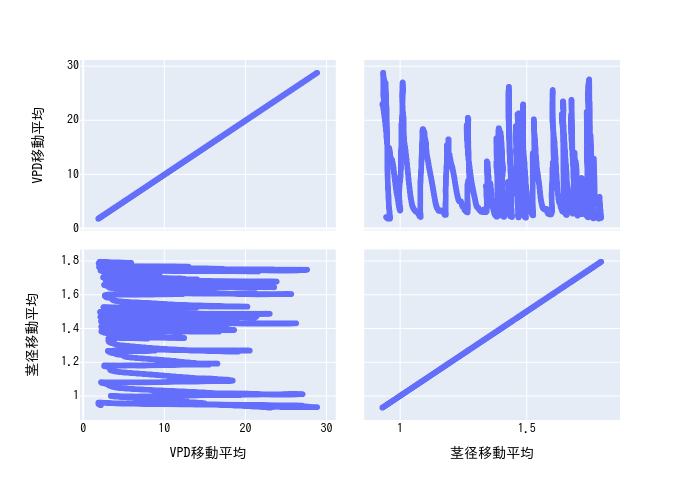

In [31]:
fig = px.scatter_matrix(df[['VPD移動平均', '茎径移動平均']])
# fig.show()
fig.write_image('my_plot.png')
Image('my_plot.png')

## 7.2.相関係数を求める

次に茎径と飽差の相関係数を求めてみましょう。相関係数は、データフレームの**corr関数**を用いることで簡単に求めることが可能です。

In [32]:
df[['VPD移動平均', '茎径移動平均']].corr()

,VPD移動平均,茎径移動平均
VPD移動平均,1.000000,-0.265251
茎径移動平均,-0.265251,1.000000


相関係数は**約-0.27**となりました。相関があるとは言えない数値です。仮説は間違いだったのでしょうか？

## 7.3.茎径のトレンドを考える

改めて茎径のグラフを見てみましょう。右肩上がりのグラフになっていることが確認できます。これは、植物が生長することにより茎も徐々に太くなっていくためです。

つまり、茎径の太さは水ストレスだけではなく植物の生長というパラメータによっても変動すると考えられます。

### ＜茎径の太さに影響しそうなパラメータ＞
$ 茎径 = 水ストレス + 植物の生長 + 植物の健康状態 + 気圧 + ... $

農業データ分析では、このように一つのデータの変動には様々な要因が関係していることを考える必要があります。


### 時系列データ分析を使ってみる

時系列データ分析では、時系列データを**トレンド**、**季節成分（周期成分）**、**残差成分**に分解して分析する手法が用いられます。トレンドとは、比較的長期的なデータの傾向を表し、季節成分（周期成分）とは、ある周期をもって変動する値を表し、それ以外を残差成分として表します。

### ＜茎径に当てはめて考えてみる＞
茎径の変動要因として考えられる水ストレスは太陽の影響を強く受けるため、ある周期性をもって変動する季節成分と考えることができます。一方、植物の生長は右肩上がりで増加していくトレンドとして考えることができます。そこで、時系列データ分析を使って、茎径データから**生長によるトレンド成分を除去**することで**純粋な水ストレスによる茎径の変動**が見れそうです。

※今回はひとまず水ストレスと生長以外の要因は無視します

時系列データ分析には**statsmodels**という統計解析＆時系列データ解析用のライブラリを用います。

時系列データを「トレンド」「季節成分」「残差成分」に分解するには**statsmodels.api.tsa.seasonal_decompose関数**を用います。引数のperiodにはデータの周期を設定します。今回は周期を60分×24=１日として分析しています。

In [33]:
result = sm.tsa.seasonal_decompose(df['茎径'], period=60*24)

df['トレンド成分'] = result.trend
df['季節成分'] = result.seasonal
df['残差成分'] = result.resid

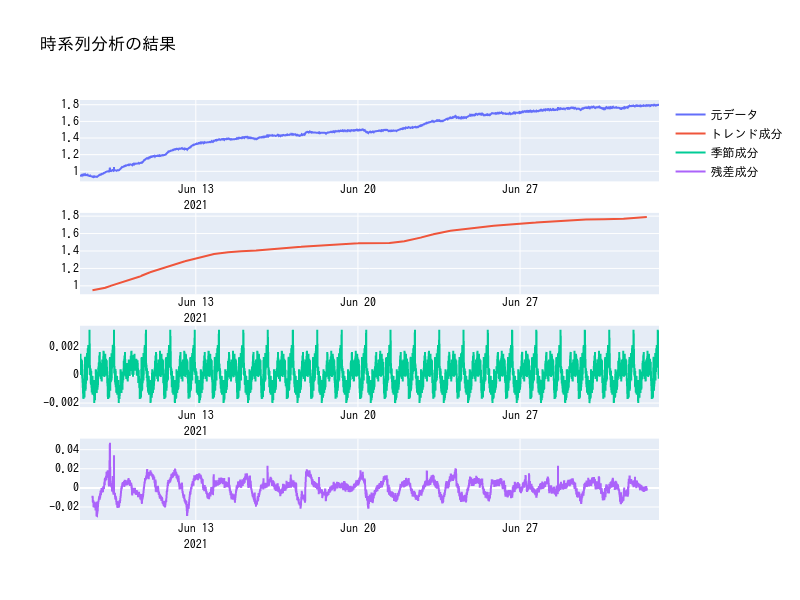

In [34]:
# それぞれの成分をグラフ表示
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['茎径'], name='元データ'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['トレンド成分'], name='トレンド成分'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['季節成分'], name='季節成分'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['日時'], y=df['残差成分'], name='残差成分'), row=4, col=1)
fig.update_layout(height=600, width=800, title_text='時系列分析の結果')
#fig.show()
fig.write_image('my_plot.png')
Image('my_plot.png')


次に茎径データからトレンド成分を除去した**「トレンド成分以外」**のデータを取得します。

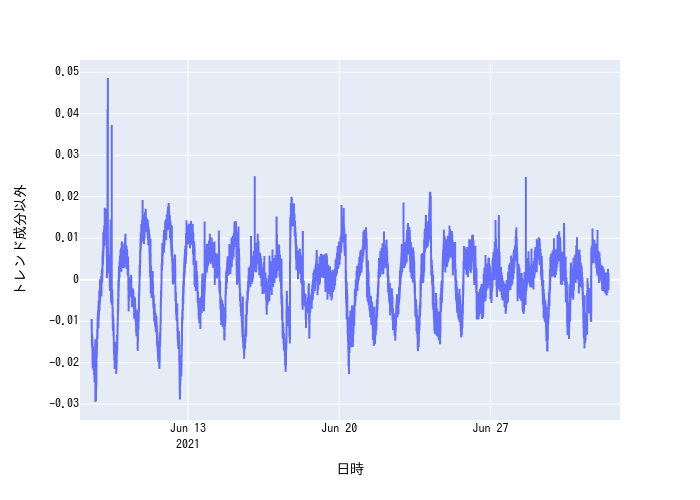

In [35]:
df['トレンド成分以外'] = df['茎径'] - df['トレンド成分']

fig = px.line(df, x='日時', y='トレンド成分以外')
fig.write_image('my_plot.png')
Image('my_plot.png')


## 7.4.トレンドを除去した茎径と飽差の相関

次に、トレンド成分を除去した茎径データと飽差データの相関を見てみます。

まずは散布図を表示します。

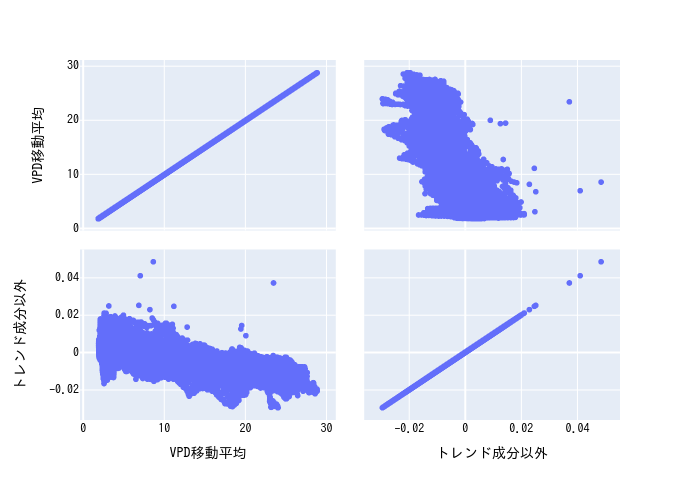

In [36]:
fig = px.scatter_matrix(df[['VPD移動平均', 'トレンド成分以外']])
#fig.show()
fig.write_image('my_plot.png')
Image('my_plot.png')

次に相関係数を求める。

In [37]:
corr = df[['VPD移動平均', '茎径移動平均', 'トレンド成分以外']].corr()
corr

,VPD移動平均,茎径移動平均,トレンド成分以外
VPD移動平均,1.000000,-0.265251,-0.751266
茎径移動平均,-0.265251,1.000000,0.101827
トレンド成分以外,-0.751266,0.101827,1.000000


飽差と茎径（トレンド成分以外）の相関係数は**約-0.75**と**強い負の相関**があることが分かりました。

どうやら仮説は正しそうです。

## 7.5.分析結果を制御に反映する

最後に、今回の分析結果を制御に反映することを考えてみます。飽差と茎径（=水ストレス）は相関関係であることがデータ分析でわかりました。それでは、**線形回帰（最小二乗法）**で飽差と茎径の関係式を求めてみましょう。

線形回帰はplotlyの関数を使うと簡単にグラフ表示することができます。**px.scatter関数**でグラフ表示する際に、オプションとして引数に**trendline='ols'**と追加するだけです。

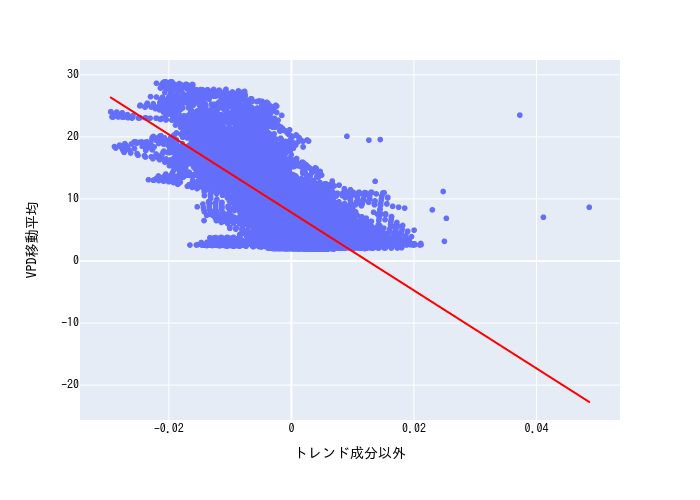

In [38]:
fig = px.scatter(df, x='トレンド成分以外', y='VPD移動平均', trendline='ols', trendline_color_override='red')
fig.write_image('my_plot.png')
Image('my_plot.png')

#### ＜最小二乗法で求めた式＞
$ VPD = -628 * 茎径 + 7.82 $

仮に、ここで茎径の変化を±0.005に抑えるとしたら、**VPDの値は約4.7～11.0hP**の間に収めれば良いことになります。


※HDだと約3.4～7.9g/m^3（一般的には3～6g/m^3と言われる）

# まとめ

* Google ColaboratoryによりPythonによるデータ分析がすぐに始められる
* 表計算データの分析にはpandas,plotyなどのライブラリ活用がオススメ
* データ分析により自動制御に活用できそうなパラメータを発見することが可能